In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
tf.config.run_functions_eagerly(True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seq = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sequence_dict.txt', sep = '\t')
print(len(seq))
seq.head()

14954


,Uniprot_ID,Fasta
0,P78410,MKMASSLAFLLLNFHVSLLLVQLLTPCSAQFSVLGPSGPILAMVGE...
1,Q8TDQ1,MPLLTLYLLLFWLSGYSIVTQITGPTTVNGLERGSLTVQCVYRSGW...
2,Q7Z624,MESRVADAGTGETARAAGGSPAVGCTTRGPVVSAPLGAARWKLLRQ...
3,O75208,MAAAAVSGALGRAGWRLLQLRCLPVARCRQALVPRAFHASAVGLRS...
4,Q8NEV1,MSGPVPSRARVYTDVNTHRPREYWDYESHVVEWGNQDDYQLVRKLG...


In [ ]:
seq_dict = {k:v for k, v in zip(seq['Uniprot_ID'],seq['Fasta'])}

In [ ]:
ppi = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ppi_human.txt', sep = '\t')
print(len(ppi))
ppi.head()

315934


,Protein_A_idx,Protein_B_idx,Interaction,Uniprot_A,Uniprot_B
0,11777,537,0.045,Q9HCE7,Q9BYM8
1,11777,5865,0.508,Q9HCE7,P51668
2,11777,10925,0.080,Q9HCE7,P17844
3,11777,6695,0.156,Q9HCE7,P38646
4,11777,4966,0.264,Q9HCE7,Q9H469


In [ ]:
ppi['Interaction'] = (ppi['Interaction'] > 0).astype(int)
ppi.head()

,Protein_A_idx,Protein_B_idx,Interaction,Uniprot_A,Uniprot_B
0,11777,537,1,Q9HCE7,Q9BYM8
1,11777,5865,1,Q9HCE7,P51668
2,11777,10925,1,Q9HCE7,P17844
3,11777,6695,1,Q9HCE7,P38646
4,11777,4966,1,Q9HCE7,Q9H469


In [ ]:
num_of_protein_A = len(ppi['Protein_A_idx'].unique())
num_of_protein_B = len(ppi['Protein_B_idx'].unique())

In [ ]:
info = pd.read_csv('/content/drive/My Drive/Colab Notebooks/protein_information.txt', sep = '\t')
print(len(info))
info.head()

14407


,Index,Uniprot_ID,Protein_names,Length,Organism_ID,Gene_name,Subcellular_location,GO(CC),Tissue_specificity,GeneID,PDB,Degree,mean_score_top_10_pred
0,0,Q8TBF5,Phosphatidylinositol-glycan biosynthesis class...,258,9606,PIGX,Endoplasmic reticulum membrane {ECO:0000250}; ...,endoplasmic reticulum membrane [GO:0005789]; i...,NaN,54965;,NA;,1,0.865861
1,1,Q8TBF4,Zinc finger CCHC-type and RNA-binding motif-co...,217,9606,ZCRB1,"Nucleus, nucleoplasm {ECO:0000269|PubMed:15146...",nucleoplasm [GO:0005654]; U12-type spliceosoma...,NaN,85437;,2E5H;,55,0.989386
2,2,Q5MIZ7,Serine/threonine-protein phosphatase 4 regulat...,849,9606,PPP4R3B,Cytoplasm {ECO:0000269|PubMed:18487071}. Cytop...,centrosome [GO:0005813]; cytoplasm [GO:0005737...,Moderately expressed in tissues and specific b...,57223;,NA;,27,0.987056
3,3,Q9NVL8,Uncharacterized protein CCDC198,296,9606,CCDC198,NaN,NaN,NaN,55195;,NA;,4,0.923086
4,4,Q8TBF2,Prostamide/prostaglandin F synthase (Prostamid...,198,9606,PRXL2B,"Cytoplasm, cytosol {ECO:0000250|UniProtKB:Q9DB...",cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,NaN,127281;,NA;,5,0.953029


In [ ]:
subcellular_location_dict = {k:v for k, v in zip(info['Index'],info['GO(CC)'])}

In [ ]:
ppi['Protein_A_location'] = ppi['Interaction']
ppi['Protein_B_location'] = ppi['Interaction']
for i in range(len(ppi)):
 if subcellular_location_dict[ppi['Protein_A_idx'][i]] == 'nan':
   ppi['Protein_A_location'][i] = 'unknown'
 else:
   ppi['Protein_A_location'][i] = (str(subcellular_location_dict[ppi['Protein_A_idx'][i]]).split('['))[0]
 if subcellular_location_dict[ppi['Protein_B_idx'][i]] == 'nan':
   ppi['Protein_B_location'][i] = 'unknown'
 else: 
   ppi['Protein_B_location'][i] = (str(subcellular_location_dict[ppi['Protein_B_idx'][i]]).split('['))[0]
ppi.head(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp

,Protein_A_idx,Protein_B_idx,Interaction,Uniprot_A,Uniprot_B,Protein_A_location,Protein_B_location
0,11777,537,1,Q9HCE7,Q9BYM8,axon,cytosol
1,11777,5865,1,Q9HCE7,P51668,axon,cytoplasm
2,11777,10925,1,Q9HCE7,P17844,axon,catalytic step 2 spliceosome
3,11777,6695,1,Q9HCE7,P38646,axon,cytoplasm
4,11777,4966,1,Q9HCE7,Q9H469,axon,cytoplasm
...,...,...,...,...,...,...,...
95,11777,14195,1,Q9HCE7,Q9UKA1,axon,cell
96,11777,8354,1,Q9HCE7,O15165,axon,early endosome membrane
97,11777,9685,1,Q9HCE7,Q8N0X7,axon,cytoplasm
98,11777,7622,1,Q9HCE7,O76024,axon,dendrite


In [ ]:
positive_list = []
negative_list = []
for i in range(len(ppi)):
  if ppi['Interaction'][i] == 1: 
    positive_list.append(i)
  else:
    negative_list.append(i)
print(len(positive_list), len(negative_list))

157967 157967


In [ ]:
import random
new_positive_list = random.sample(positive_list,8000)
new_negative_list = random.sample(negative_list,2000)
new_idx = new_positive_list + new_negative_list

df = pd.DataFrame()
df['Protein_A_idx'] = ppi['Protein_A_idx'][new_idx]
df['Protein_B_idx'] = ppi['Protein_B_idx'][new_idx]
df['Protein_A_location'] = ppi['Protein_A_location'][new_idx]
df['Protein_B_location'] = ppi['Protein_B_location'][new_idx]
df['Protein_A_sequence'] = ppi['Uniprot_A'][new_idx]
df['Protein_B_sequence'] = ppi['Uniprot_B'][new_idx]
df['Interaction'] = ppi['Interaction'][new_idx]
df

,Protein_A_idx,Protein_B_idx,Protein_A_location,Protein_B_location,Protein_A_sequence,Protein_B_sequence,Interaction
98400,4387,11827,cell,actin filament,P84022,P31146,1
74921,3509,13758,apical plasma membrane,extracellular exosome,P21860,P27701,1
54827,10084,1995,cytoplasm,cytoplasm,Q9NQW7,Q6FI81,1
112609,350,12865,cytosol,cytoplasm,Q9Y2T3,P55060,1
122532,2469,9826,cell,cytoplasm,Q05086,P49720,1
...,...,...,...,...,...,...,...
228809,9931,14053,nucleoplasm,nan,O00534,Q9H1Q7,0
233914,11758,13825,chromatin,endoplasmic reticulum,P17275,B0YJ81,0
199622,1701,2040,cytosol,nan,Q9HAV0,Q53HC5,0
262198,11984,13553,beta-catenin-TCF complex,endoplasmic reticulum membrane,Q04727,O75845,0


In [ ]:
for i in range(len(df)):
  df['Protein_A_sequence'].values[i] = seq_dict[df['Protein_A_sequence'].values[i]]
  df['Protein_B_sequence'].values[i] = seq_dict[df['Protein_B_sequence'].values[i]]
df

,Protein_A_idx,Protein_B_idx,Protein_A_location,Protein_B_location,Protein_A_sequence,Protein_B_sequence,Interaction
98400,4387,11827,cell,actin filament,MSSILPFTPPIVKRLLGWKKGEQNGQEEKWCEKAVKSLVKKLKKTG...,MSRQVVRSSKFRHVFGQPAKADQCYEDVRVSQTTWDSGFCAVNPKF...,1
74921,3509,13758,apical plasma membrane,extracellular exosome,MRANDALQVLGLLFSLARGSEVGNSQAVCPGTLNGLSVTGDAENQY...,MGSACIKVTKYFLFLFNLIFFILGAVILGFGVWILADKSSFISVLQ...,1
54827,10084,1995,cytoplasm,cytoplasm,MPPKVTSELLRQLRQAMRNSEYVTEPIQAYIIPSGDAHQSEYIAPC...,MADFGISAGQFVAVVWDKSSPVEALKGLVDKLQALTGNEGRVSVEN...,1
112609,350,12865,cytosol,cytoplasm,MCAAQMPPLAHIFRGTFVHSTWTCPMEVLRDHLLGVSDSGKIVFLE...,MELSDANLQTLTEYLKKTLDPDPAIRRPAEKFLESVEGNQNYPLLL...,1
122532,2469,9826,cell,cytoplasm,MEKLHQCYWKSGEPQSDDIEASRMKRAAAKHLIERYYHQLTEGCGN...,MSIMSYNGGAVMAMKGKNCVAIAADRRFGIQAQMVTTDFQKIFPMG...,1
...,...,...,...,...,...,...,...
228809,9931,14053,nucleoplasm,nan,MVHFCGLLTLHREPVPLKSISVSVNIYEFVAGVSATLNYENEEKVP...,MVFCLSSEEPRRPLRSDMVHFQASEVQQLLHNKFVVILGDSIQRAV...,0
233914,11758,13825,chromatin,endoplasmic reticulum,MCTKMEQPFYHDDSYTATGYGRAPGGLSLHDYKLLKPSLAVNLADP...,MGRLTEAAAAGSGSRAAGWAGSPPTLLPLSPTSPRCAATMASSDED...,0
199622,1701,2040,cytosol,nan,MSELEQLRQEAEQLRNQIQDARKACNDATLVQITSNMDSVGRIQMR...,MAESGGSSGGAGGGGAFGAGPGPERPNSTADKNGALKCTFSAPSHS...,0
262198,11984,13553,beta-catenin-TCF complex,endoplasmic reticulum membrane,MIRDLSKMYPQTRHPAPHQPAQPFKFTISESCDRIKEEFQFLQAQY...,MDLVLRVADYYFFTPYVYPATWPEDDIFRQAISLLIVTNVGAYILY...,0


In [ ]:
words = list(set(df["Protein_A_sequence"].values) | set(df["Protein_B_sequence"].values))
chars = set([w_i for w in words for w_i in w])
chars = sorted(list(chars))
print(chars)

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']


In [ ]:
char_to_index = {c: i + 2 for i, c in enumerate(chars)}
index_to_char = {}
for key, value in char_to_index.items():
  index_to_char[value] = key

In [ ]:
max_len_char = 1000

def padding_char_indice(char_indice, max_len_char):
  if len(char_indice) >= max_len_char: 
    return char_indice[0:max_len_char+1]
  else:
    return char_indice + ['0']*(max_len_char - len(char_indice))

def integer_coding(sentences):
  char_indice = [char_to_index[char] for char in sentences]
  char_indice = padding_char_indice(char_indice, max_len_char)
  return char_indice

for i in range(len(df)):
  df['Protein_A_sequence'].values[i] =  integer_coding(list(df['Protein_A_sequence'].values[i]))
  df['Protein_B_sequence'].values[i] =  integer_coding(list(df['Protein_B_sequence'].values[i]))

In [ ]:
df

,Protein_A_idx,Protein_B_idx,Protein_A_location,Protein_B_location,Protein_A_sequence,Protein_B_sequence,Interaction
98400,4387,11827,cell,actin filament,"[12, 17, 17, 9, 11, 14, 6, 18, 14, 14, 9, 20, ...","[12, 17, 16, 15, 20, 20, 16, 17, 17, 10, 6, 16...",1
74921,3509,13758,apical plasma membrane,extracellular exosome,"[12, 16, 2, 13, 4, 2, 11, 15, 20, 11, 7, 11, 1...","[12, 7, 17, 2, 3, 9, 10, 20, 18, 10, 22, 6, 11...",1
54827,10084,1995,cytoplasm,cytoplasm,"[12, 14, 14, 10, 20, 18, 17, 5, 11, 11, 16, 15...","[12, 2, 4, 6, 7, 9, 17, 2, 7, 15, 6, 20, 2, 20...",1
112609,350,12865,cytosol,cytoplasm,"[12, 3, 2, 2, 15, 12, 14, 14, 11, 2, 8, 9, 6, ...","[12, 5, 11, 17, 4, 2, 13, 11, 15, 18, 11, 18, ...",1
122532,2469,9826,cell,cytoplasm,"[12, 5, 10, 11, 8, 15, 3, 22, 21, 10, 17, 7, 5...","[12, 17, 9, 12, 17, 22, 13, 7, 7, 2, 20, 12, 2...",1
...,...,...,...,...,...,...,...
228809,9931,14053,nucleoplasm,nan,"[12, 20, 8, 6, 3, 7, 11, 11, 18, 11, 8, 16, 5,...","[12, 20, 6, 3, 11, 17, 17, 5, 5, 14, 16, 16, 1...",0
233914,11758,13825,chromatin,endoplasmic reticulum,"[12, 3, 18, 10, 12, 5, 15, 14, 6, 22, 8, 4, 4,...","[12, 7, 16, 11, 18, 5, 2, 2, 2, 2, 7, 17, 7, 1...",0
199622,1701,2040,cytosol,nan,"[12, 17, 5, 11, 5, 15, 11, 16, 15, 5, 2, 5, 15...","[12, 2, 5, 17, 7, 7, 17, 17, 7, 7, 2, 7, 7, 7,...",0
262198,11984,13553,beta-catenin-TCF complex,endoplasmic reticulum membrane,"[12, 9, 16, 4, 11, 17, 10, 12, 22, 14, 15, 18,...","[12, 4, 11, 20, 11, 16, 20, 2, 4, 22, 22, 6, 6...",0


In [ ]:
df['Sequence'] = df['Protein_A_sequence']
for i in range(len(df)):
  df['Sequence'].values[i] = df['Protein_A_sequence'].values[i] + df['Protein_B_sequence'].values[i]
df

,Protein_A_idx,Protein_B_idx,Protein_A_location,Protein_B_location,Protein_A_sequence,Protein_B_sequence,Interaction,Sequence
98400,4387,11827,cell,actin filament,"[12, 17, 17, 9, 11, 14, 6, 18, 14, 14, 9, 20, ...","[12, 17, 16, 15, 20, 20, 16, 17, 17, 10, 6, 16...",1,"[12, 17, 17, 9, 11, 14, 6, 18, 14, 14, 9, 20, ..."
74921,3509,13758,apical plasma membrane,extracellular exosome,"[12, 16, 2, 13, 4, 2, 11, 15, 20, 11, 7, 11, 1...","[12, 7, 17, 2, 3, 9, 10, 20, 18, 10, 22, 6, 11...",1,"[12, 16, 2, 13, 4, 2, 11, 15, 20, 11, 7, 11, 1..."
54827,10084,1995,cytoplasm,cytoplasm,"[12, 14, 14, 10, 20, 18, 17, 5, 11, 11, 16, 15...","[12, 2, 4, 6, 7, 9, 17, 2, 7, 15, 6, 20, 2, 20...",1,"[12, 14, 14, 10, 20, 18, 17, 5, 11, 11, 16, 15..."
112609,350,12865,cytosol,cytoplasm,"[12, 3, 2, 2, 15, 12, 14, 14, 11, 2, 8, 9, 6, ...","[12, 5, 11, 17, 4, 2, 13, 11, 15, 18, 11, 18, ...",1,"[12, 3, 2, 2, 15, 12, 14, 14, 11, 2, 8, 9, 6, ..."
122532,2469,9826,cell,cytoplasm,"[12, 5, 10, 11, 8, 15, 3, 22, 21, 10, 17, 7, 5...","[12, 17, 9, 12, 17, 22, 13, 7, 7, 2, 20, 12, 2...",1,"[12, 5, 10, 11, 8, 15, 3, 22, 21, 10, 17, 7, 5..."
...,...,...,...,...,...,...,...,...
228809,9931,14053,nucleoplasm,nan,"[12, 20, 8, 6, 3, 7, 11, 11, 18, 11, 8, 16, 5,...","[12, 20, 6, 3, 11, 17, 17, 5, 5, 14, 16, 16, 1...",0,"[12, 20, 8, 6, 3, 7, 11, 11, 18, 11, 8, 16, 5,..."
233914,11758,13825,chromatin,endoplasmic reticulum,"[12, 3, 18, 10, 12, 5, 15, 14, 6, 22, 8, 4, 4,...","[12, 7, 16, 11, 18, 5, 2, 2, 2, 2, 7, 17, 7, 1...",0,"[12, 3, 18, 10, 12, 5, 15, 14, 6, 22, 8, 4, 4,..."
199622,1701,2040,cytosol,nan,"[12, 17, 5, 11, 5, 15, 11, 16, 15, 5, 2, 5, 15...","[12, 2, 5, 17, 7, 7, 17, 17, 7, 7, 2, 7, 7, 7,...",0,"[12, 17, 5, 11, 5, 15, 11, 16, 15, 5, 2, 5, 15..."
262198,11984,13553,beta-catenin-TCF complex,endoplasmic reticulum membrane,"[12, 9, 16, 4, 11, 17, 10, 12, 22, 14, 15, 18,...","[12, 4, 11, 20, 11, 16, 20, 2, 4, 22, 22, 6, 6...",0,"[12, 9, 16, 4, 11, 17, 10, 12, 22, 14, 15, 18,..."


In [ ]:
dataset = pd.DataFrame()
dataset['x'] = df['Sequence']
dataset['y'] = df['Interaction']
dataset

,x,y
98400,"[12, 17, 17, 9, 11, 14, 6, 18, 14, 14, 9, 20, ...",1
74921,"[12, 16, 2, 13, 4, 2, 11, 15, 20, 11, 7, 11, 1...",1
54827,"[12, 14, 14, 10, 20, 18, 17, 5, 11, 11, 16, 15...",1
112609,"[12, 3, 2, 2, 15, 12, 14, 14, 11, 2, 8, 9, 6, ...",1
122532,"[12, 5, 10, 11, 8, 15, 3, 22, 21, 10, 17, 7, 5...",1
...,...,...
228809,"[12, 20, 8, 6, 3, 7, 11, 11, 18, 11, 8, 16, 5,...",0
233914,"[12, 3, 18, 10, 12, 5, 15, 14, 6, 22, 8, 4, 4,...",0
199622,"[12, 17, 5, 11, 5, 15, 11, 16, 15, 5, 2, 5, 15...",0
262198,"[12, 9, 16, 4, 11, 17, 10, 12, 22, 14, 15, 18,...",0


In [ ]:
def vectorize(sequences, dimension = 23):
  results = np.zeros((2000, dimension))
  for i, sequence in enumerate(sequences[:2000]):
    try:
      results[i, int(sequence)] = 1
    except TypeError as e :
      print(sequence)
  return results.astype('float32')

for i in range(len(dataset['x'])):
  dataset['x'].values[i] = vectorize(dataset['x'].values[i])

dataset

,x,y
98400,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
74921,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
54827,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
112609,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
122532,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
...,...,...
228809,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
233914,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
199622,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
262198,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [ ]:
data_x = np.stack(
                   dataset['x'].values
)
data_y = np.stack(
                   dataset['y'].values
).T
print(data_x.shape, data_y.shape)

(10000, 2000, 23) (10000,)


In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size = 0.1)
valid_x, test_x, valid_y, test_y = train_test_split(valid_x, valid_y, test_size = 0.5)
print(
    train_x.shape, train_y.shape, 
    valid_x.shape, valid_y.shape,
    test_x.shape, test_y.shape
)

(9000, 2000, 23) (9000,) (500, 2000, 23) (500,) (500, 2000, 23) (500,)


In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation = 'relu', input_shape = (46000, )))
model.add(keras.layers.Dense(16, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    x = train_x, 
    y = train_y, 
    batch_size = 512, 
    epochs = 20, 
    verbose = 'auto',
    validation_data = (valid_x, valid_y),
    shuffle = True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


18/18 [==============================] - 2s 106ms/step - loss: 0.5110 - accuracy: 0.7937 - val_loss: 0.4904 - val_accuracy: 0.8020
Epoch 2/20
18/18 [==============================] - 2s 122ms/step - loss: 0.4527 - accuracy: 0.7990 - val_loss: 0.4782 - val_accuracy: 0.8020
Epoch 3/20
18/18 [==============================] - 2s 107ms/step - loss: 0.3963 - accuracy: 0.7994 - val_loss: 0.4575 - val_accuracy: 0.8020
Epoch 4/20
18/18 [==============================] - 2s 112ms/step - loss: 0.3344 - accuracy: 0.8080 - val_loss: 0.4397 - val_accuracy: 0.8100
Epoch 5/20
18/18 [==============================] - 2s 104ms/step - loss: 0.2775 - accuracy: 0.8430 - val_loss: 0.4615 - val_accuracy: 0.8040
Epoch 6/20
18/18 [==============================] - 2s 130ms/step - loss: 0.2275 - accuracy: 0.8844 - val_loss: 0.4687 - val_accuracy: 0.8260
Epoch 7/20
18/18 [==============================] - 2s 126ms/step - loss: 0.1978 - accuracy: 0.9321 - val_loss: 0.5202 - val_accuracy: 0.8280
Epoch 8/20
18/18 

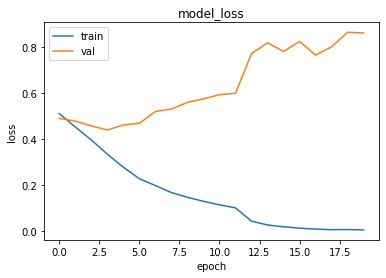

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [ ]:
model.evaluate(
    x = test_x,
    y = test_y
)

 8/16 [==============>...............] - ETA: 0s - loss: 0.7808 - accuracy: 0.8086

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


16/16 [==============================] - 0s 15ms/step - loss: 0.7860 - accuracy: 0.8220


[0.7860332131385803, 0.8220000267028809]